<a href="https://colab.research.google.com/github/laurosampaio/MESC_IA_2023_Data_Science_Seminario_WQI/blob/main/MESC_IA_2023_2_DS_Semin%C3%A1rioV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carrega dados do arquivo

In [ ]:
#Imports
import pandas as pd
import io
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from sklearn.impute import KNNImputer
import missingno as msno
import seaborn as sns


from google.colab import drive
drive.mount('/content/drive', force_remount=True)


url = '/content/drive/MyDrive/data/converted_distinct_WQI_V3.csv'
df = pd.read_csv(url,sep=';',header=0)

Mounted at /content/drive


In [ ]:
df

,GEMS,Date,pH,BOD,TP,O2Dis,NO3N,TEMP,FECALCOLI,NO2N,NH4N,TS,TURB
0,BRA00005,01/01/1979,6.92,1.4,0.19,7.2,0.19,NaN,3.3,0.001,NaN,NaN,NaN
1,BRA00005,01/02/1979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BRA00005,01/03/1979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BRA00005,01/04/1979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BRA00005,01/05/1979,6.95,2.4,0.06,7.6,0.30,23.0,2.3,0.023,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,BRA02280,01/08/2015,6.90,2.0,0.03,9.2,1.51,22.0,490.0,0.020,0.14,91.0,6.20
495,BRA02280,01/09/2015,7.30,2.0,0.09,7.6,1.50,21.0,4500.0,0.020,0.50,NaN,3.90
496,BRA02280,01/10/2015,7.00,2.0,0.08,7.6,1.24,25.0,1300.0,0.010,0.16,NaN,1.98
497,BRA02280,01/11/2015,7.10,2.0,0.08,6.8,1.32,25.0,2300.0,0.020,0.10,NaN,13.80


# Exibe Percentual de registros com todos os valores para o WQI


Percentual de linhas com dados completos para o cálculo de WQI: 4.21%


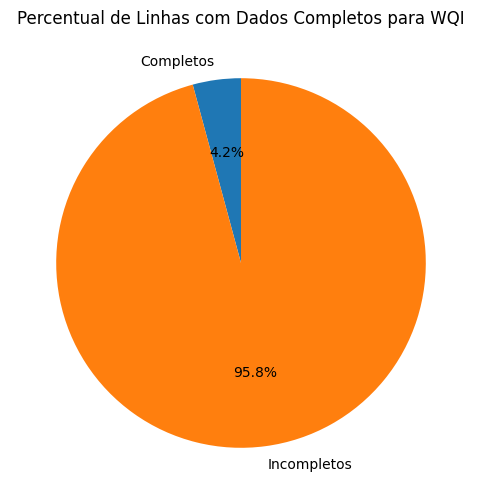

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GEMS       499 non-null    object 
 1   Date       499 non-null    object 
 2   pH         400 non-null    float64
 3   BOD        398 non-null    float64
 4   TP         354 non-null    float64
 5   O2Dis      394 non-null    float64
 6   NO3N       280 non-null    float64
 7   TEMP       347 non-null    float64
 8   FECALCOLI  224 non-null    float64
 9   NO2N       281 non-null    float64
 10  NH4N       237 non-null    float64
 11  TS         234 non-null    float64
 12  TURB       111 non-null    float64
dtypes: float64(11), object(2)
memory usage: 50.8+ KB


In [ ]:
filtered_df = df

# Verificando as linhas que possuem todos os dados necessários para o cálculo de WQI
complete_data_rows = filtered_df.dropna(subset=['pH', 'BOD', 'TP', 'O2Dis', 'NO3N', 'NO2N', 'NH4N','TEMP', 'FECALCOLI', 'TS', 'TURB'])

# Calculando o percentual de linhas com dados completos
percent_complete_data = (len(complete_data_rows) / len(filtered_df)) * 100
print(f"\nPercentual de linhas com dados completos para o cálculo de WQI: {percent_complete_data:.2f}%")

# Criando um gráfico de pizza com o percentual de linhas com dados completos
labels = ['Completos', 'Incompletos']
sizes = [percent_complete_data, 100 - percent_complete_data]
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Percentual de Linhas com Dados Completos para WQI')
plt.show()

filtered_df.info()

# Exibe o percentual por coluna de dados preenchidos

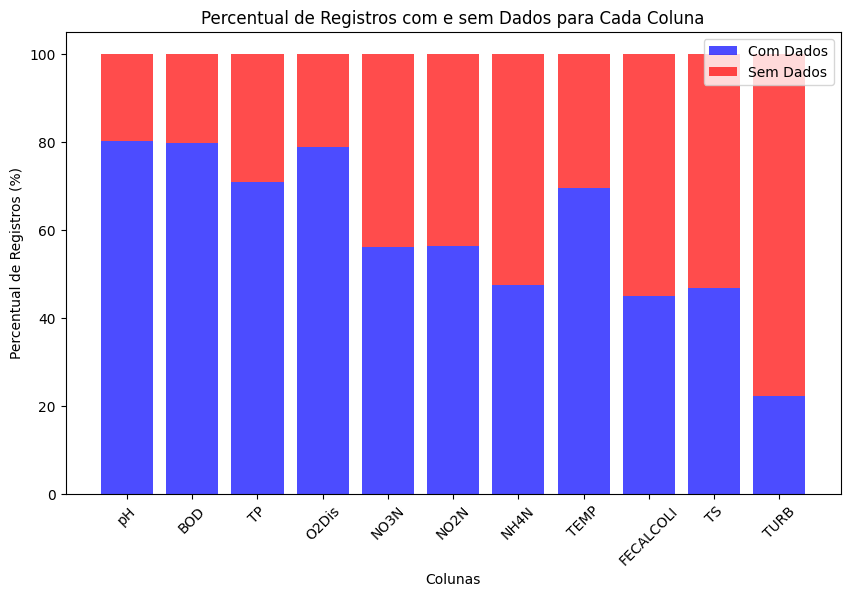

In [ ]:
# Calculando o percentual de registros com dados e sem dados para cada coluna
columns = ['pH', 'BOD', 'TP', 'O2Dis', 'NO3N', 'NO2N', 'NH4N','TEMP', 'FECALCOLI', 'TS', 'TURB']
data_presence_percentage = []
for column in columns:
    with_data = len(df[df[column].notnull()]) / len(df) * 100
    data_presence_percentage.append(with_data)

# Calculando o percentual de registros sem dados para cada coluna
data_absence_percentage = [100 - percentage for percentage in data_presence_percentage]

# Criando o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(columns, data_presence_percentage, label='Com Dados', color='b', alpha=0.7)
plt.bar(columns, data_absence_percentage, bottom=data_presence_percentage, label='Sem Dados', color='r', alpha=0.7)
plt.xlabel('Colunas')
plt.ylabel('Percentual de Registros (%)')
plt.title('Percentual de Registros com e sem Dados para Cada Coluna')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Total de valores válidos para cada coluna

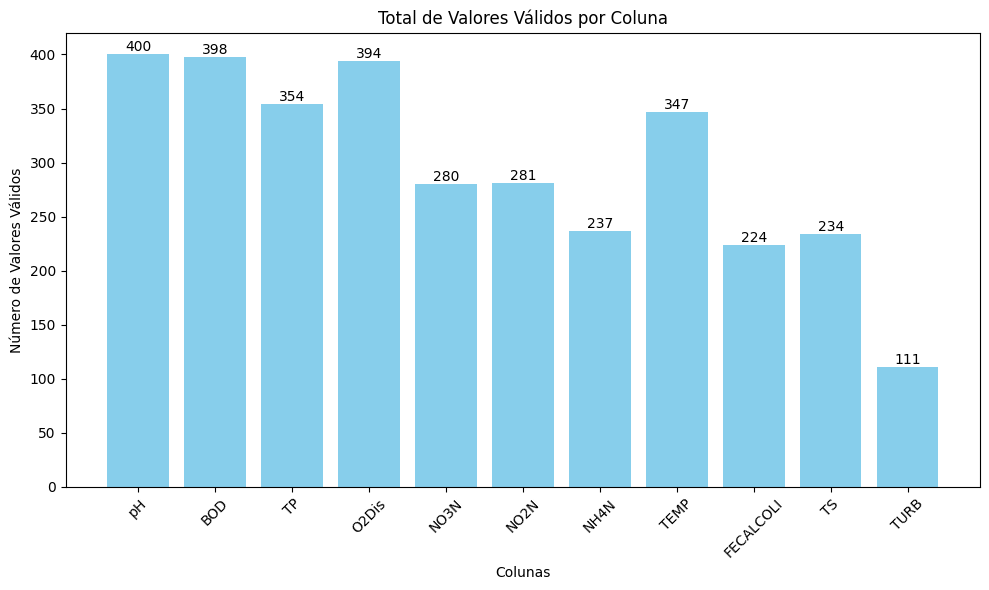

In [ ]:
# Calculando o total de valores válidos para cada coluna
valid_value_counts = df[['pH', 'BOD', 'TP', 'O2Dis', 'NO3N', 'NO2N', 'NH4N','TEMP', 'FECALCOLI', 'TS', 'TURB']].count()

# Criando o gráfico de barras com os valores numéricos
plt.figure(figsize=(10, 6))
plt.bar(valid_value_counts.index, valid_value_counts.values, color='skyblue')
plt.xlabel('Colunas')
plt.ylabel('Número de Valores Válidos')
plt.title('Total de Valores Válidos por Coluna')
plt.xticks(rotation=45)
plt.tight_layout()

# Adicionando os valores numéricos acima das barras
for index, value in enumerate(valid_value_counts.values):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()


<ipython-input-49-2ee6c061ca10>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])
<ipython-input-49-2ee6c061ca10>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_colors))


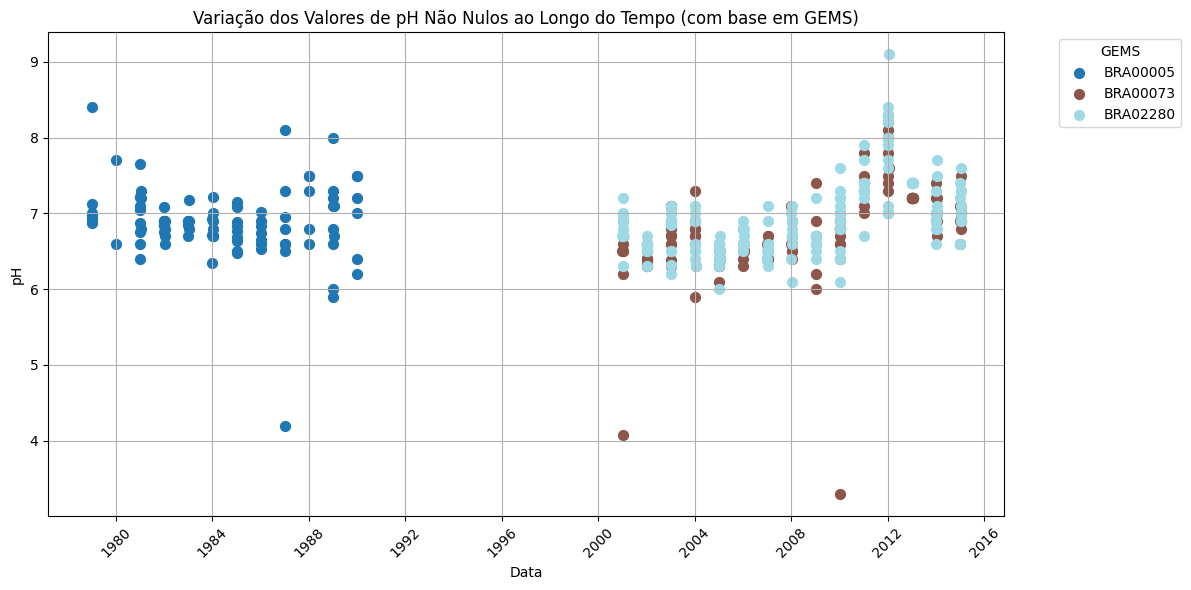

In [ ]:
# Filtrando linhas com valores não nulos na coluna 'pH'
filtered_df = df.dropna(subset=['pH'])

# Verificando se a coluna 'Date' está no formato de data
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])

# Criando um mapeamento de cores baseado nos valores únicos da coluna 'GEMS'
unique_colors = list(filtered_df['GEMS'].unique())
color_map = plt.cm.get_cmap('tab20', len(unique_colors))

# Criando o gráfico de dispersão com 'Date' no eixo x e 'pH' no eixo y, e usando cores com base em 'GEMS'
plt.figure(figsize=(12, 6))
for idx, color in enumerate(unique_colors):
    subset_df = filtered_df[filtered_df['GEMS'] == color]
    plt.scatter(subset_df['Date'], subset_df['pH'], color=color_map(idx), label=color, s=50)

plt.xlabel('Data')
plt.ylabel('pH')
plt.title('Variação dos Valores de pH Não Nulos ao Longo do Tempo (com base em GEMS)')
plt.xticks(rotation=45)
plt.legend(title='GEMS', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

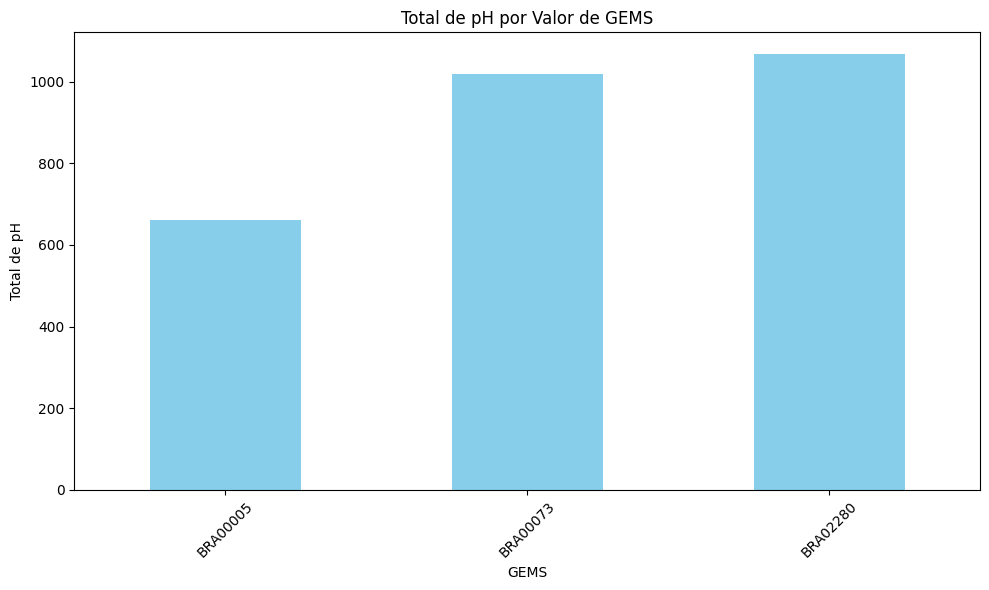

In [ ]:
# Agrupando os dados por "GEMS" e calculando o total de "pH" para cada grupo
gems_pH_totals = df.groupby('GEMS')['pH'].sum()

# Criando o gráfico de barras com os totais de "pH" para cada "GEMS"
plt.figure(figsize=(10, 6))
gems_pH_totals.plot(kind='bar', color='skyblue')
plt.xlabel('GEMS')
plt.ylabel('Total de pH')
plt.title('Total de pH por Valor de GEMS')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 319 to 498
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GEMS       180 non-null    object 
 1   Date       180 non-null    object 
 2   pH         154 non-null    float64
 3   BOD        154 non-null    float64
 4   TP         153 non-null    float64
 5   O2Dis      150 non-null    float64
 6   NO3N       113 non-null    float64
 7   TEMP       144 non-null    float64
 8   FECALCOLI  68 non-null     float64
 9   NO2N       119 non-null    float64
 10  NH4N       120 non-null    float64
 11  TS         120 non-null    float64
 12  TURB       56 non-null     float64
dtypes: float64(11), object(2)
memory usage: 19.7+ KB


<ipython-input-51-4422e8238731>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])
<ipython-input-51-4422e8238731>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = filtered_df['Date'].dt.year


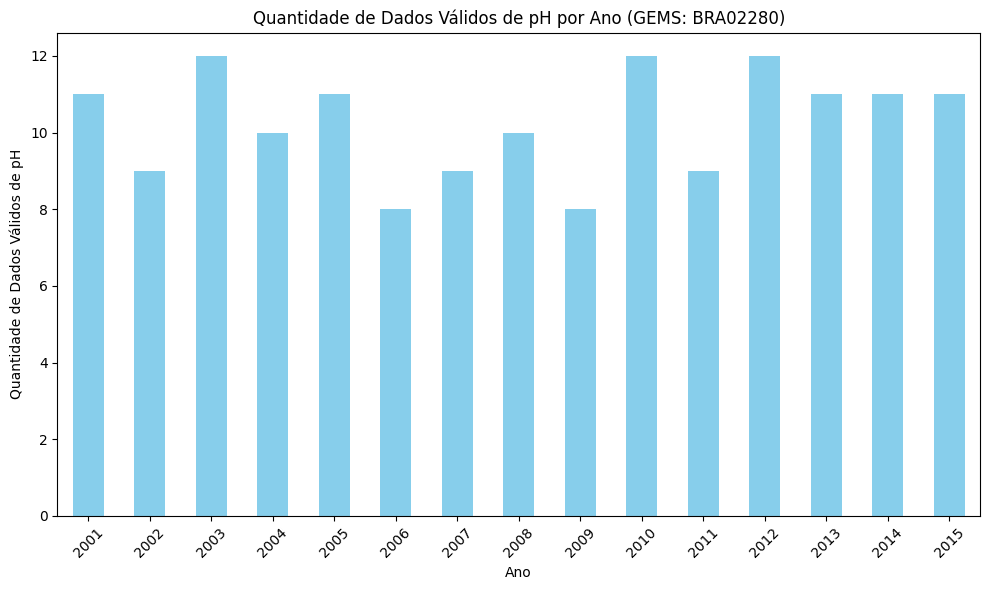

In [ ]:
# Filtrando as linhas em que 'GEMS' seja igual a 'BRA02280'
filtered_df = df[df['GEMS'] == 'BRA02280']

filtered_df.info()

# Verificando se a coluna 'Date' está no formato de data
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])

# Extraindo o ano da coluna 'Date'
filtered_df['Year'] = filtered_df['Date'].dt.year

# Criando um gráfico de barras que mostra a quantidade de dados válidos de 'pH' por ano
plt.figure(figsize=(10, 6))
valid_pH_counts = filtered_df.groupby('Year')['pH'].count()
valid_pH_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Dados Válidos de pH')
plt.title('Quantidade de Dados Válidos de pH por Ano (GEMS: BRA02280)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


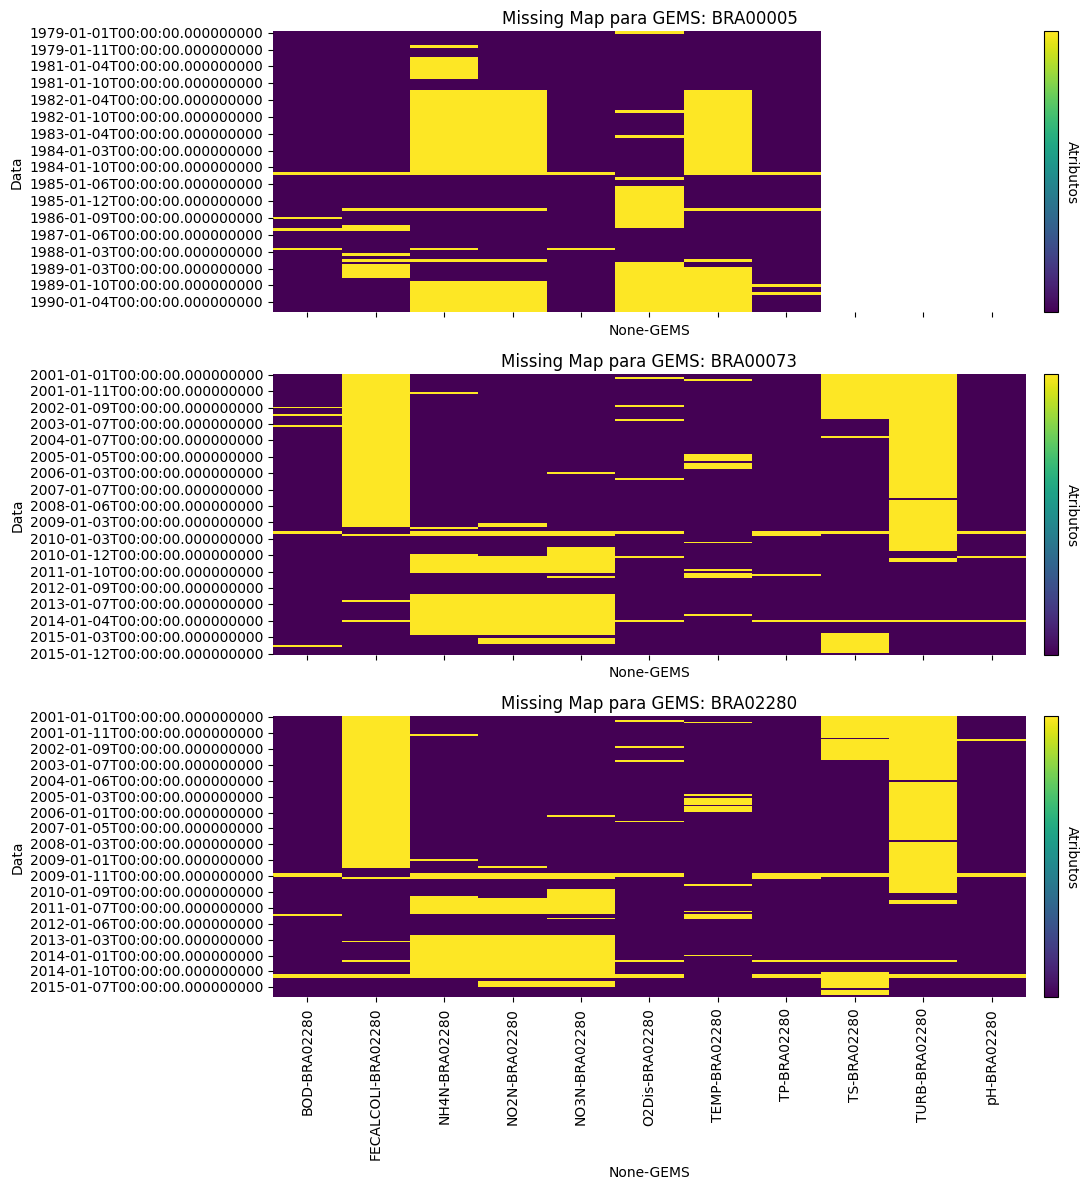

In [ ]:
# Lista das colunas de interesse
colunas_interesse = ['pH', 'BOD', 'TP', 'O2Dis', 'NO3N', 'NO2N', 'NH4N','TEMP', 'FECALCOLI', 'TS', 'TURB']

# Convertendo 'Date' para datetime e 'GEMS' para strings
df['Date'] = pd.to_datetime(df['Date'])
df['GEMS'] = df['GEMS'].astype(str)

# Criando subplots para cada estação de GEMS
gem_stations = df['GEMS'].unique()

# Calculando o número de linhas e colunas para os subplots
num_rows = len(gem_stations)
num_cols = 1

# Criando subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows), sharex=True)

# Normalizando cores para atributos
norm = mcolors.Normalize(vmin=0, vmax=len(colunas_interesse))
colors = plt.cm.viridis(norm(range(len(colunas_interesse))))

# Iterando sobre cada estação de GEMS e criando o missing map
for i, (gem_station, color) in enumerate(zip(gem_stations, colors)):
    # Filtrando o DataFrame para a estação de GEMS atual
    filtered_df = df[df['GEMS'] == gem_station]

    # Criando o missing map para a estação de GEMS atual
    sns.heatmap(filtered_df.pivot_table(index='Date', columns='GEMS', values=colunas_interesse).isnull(), cmap='viridis', cbar=False, ax=axs[i])

    # Configurando títulos e rótulos
    axs[i].set_title(f'Missing Map para GEMS: {gem_station}')
    axs[i].set_ylabel('Data')

    # Adicionando legenda das cores
    sm = ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axs[i], pad=0.02)
    cbar.set_label('Atributos', rotation=270, labelpad=15)
    cbar.set_ticks([])  # Remover os ticks da barra de cores

# Ajustando espaçamento entre os subplots
plt.tight_layout()

# Exibindo os subplots
plt.show()


In [ ]:
# Contando o número de valores não nulos para cada estação de GEMS nas colunas de interesse
dados_validos_por_gems = df.groupby('GEMS')[colunas_interesse].count().sum(axis=1)

# Identificando a estação de GEMS com mais dados válidos
gems_com_mais_dados_validos = dados_validos_por_gems.idxmax()

print(f"A estação de GEMS com mais dados válidos é: {gems_com_mais_dados_validos}")


A estação de GEMS com mais dados válidos é: BRA02280


<ipython-input-54-8035ce81b210>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[cols_to_impute] = imputer.fit_transform(filtered_data[cols_to_impute])


<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 319 to 498
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   GEMS       180 non-null    object        
 1   Date       180 non-null    datetime64[ns]
 2   pH         180 non-null    float64       
 3   BOD        180 non-null    float64       
 4   TP         180 non-null    float64       
 5   O2Dis      180 non-null    float64       
 6   NO3N       180 non-null    float64       
 7   TEMP       180 non-null    float64       
 8   FECALCOLI  180 non-null    float64       
 9   NO2N       180 non-null    float64       
 10  NH4N       180 non-null    float64       
 11  TS         180 non-null    float64       
 12  TURB       180 non-null    float64       
dtypes: datetime64[ns](1), float64(11), object(1)
memory usage: 19.7+ KB


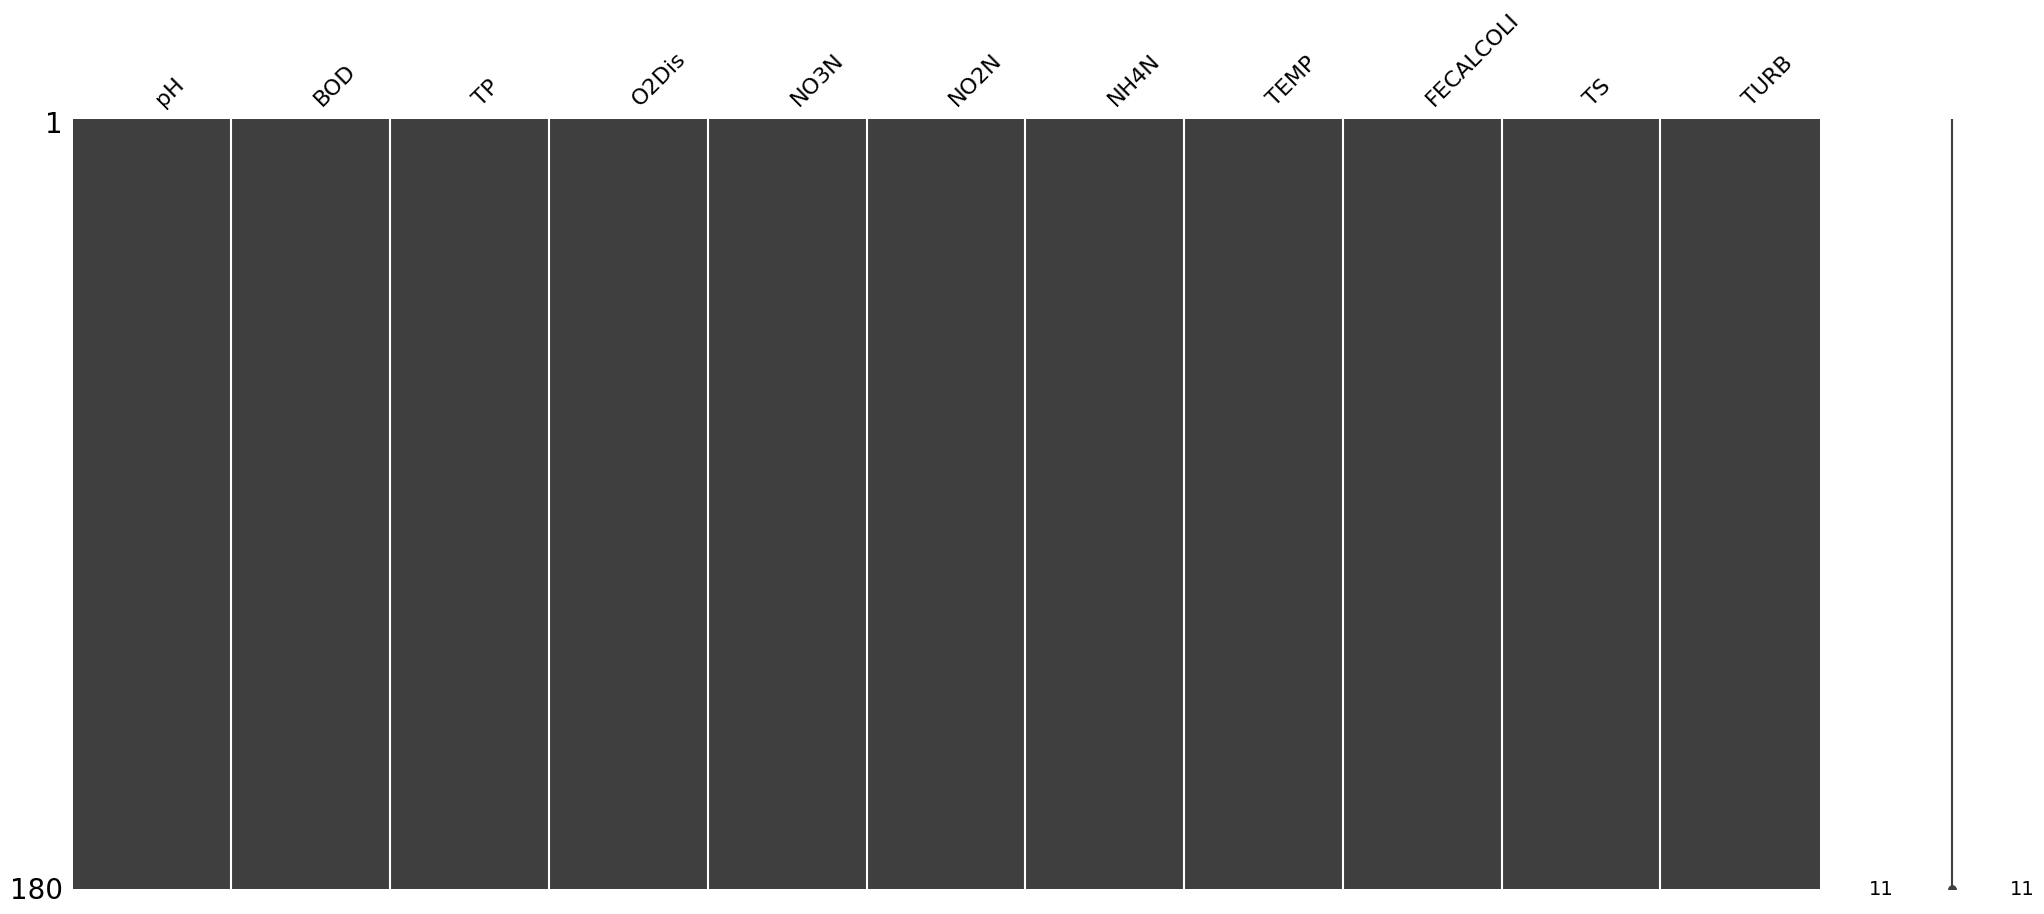

In [ ]:
# Filtro para GEMS = "BRA02280"
filtered_data = df[(df['GEMS'] == 'BRA02280')]

# Selecionando as colunas para aplicar o KNN
cols_to_impute = ['pH', 'BOD', 'TP', 'O2Dis', 'NO3N', 'NO2N', 'NH4N','TEMP', 'FECALCOLI', 'TS', 'TURB']

# Criando o objeto KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Aplicando o KNN para preencher os valores faltantes
filtered_data[cols_to_impute] = imputer.fit_transform(filtered_data[cols_to_impute])

# Gere o gráfico de missing map
msno.matrix(filtered_data[cols_to_impute])

filtered_data.info()


<ipython-input-55-38aadae02000>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Date'] = pd.to_datetime(filtered_data['Date'])


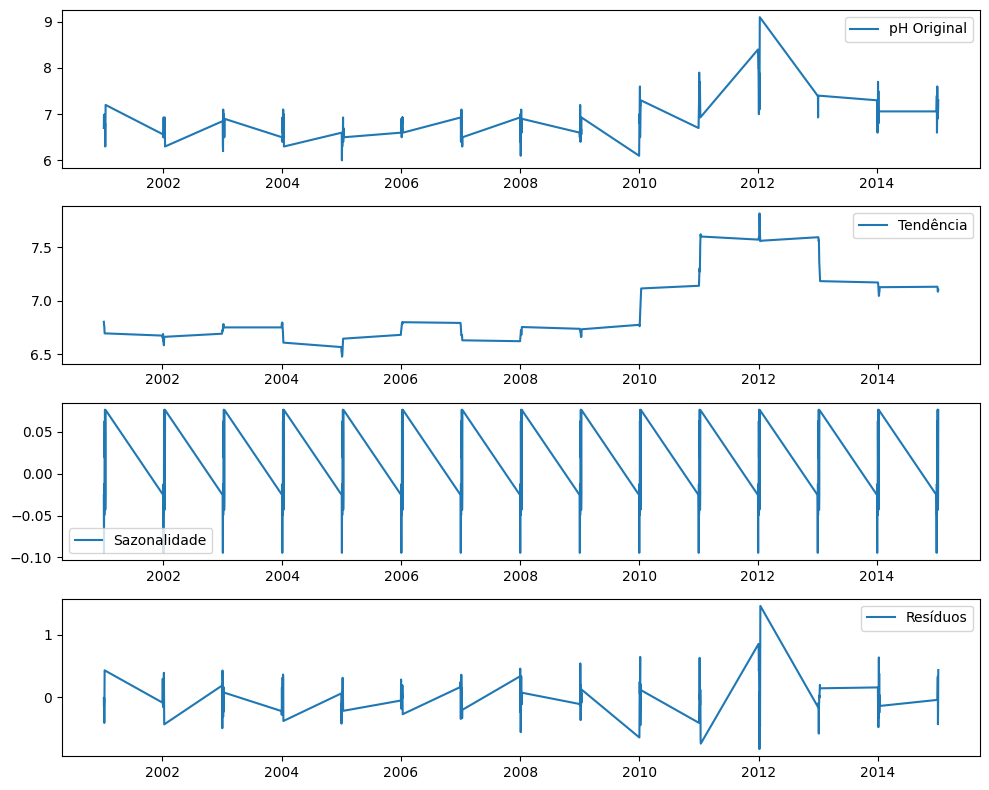

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

# Converter a coluna 'Date' para o tipo DateTime
filtered_data['Date'] = pd.to_datetime(filtered_data['Date'])

# Definir a coluna 'Date' como índice do DataFrame
filtered_data.set_index('Date', inplace=True)

# Verificar se há sazonalidade nos dados de pH
result = seasonal_decompose(filtered_data['pH'], model='additive', period=12)  # period=12 indica sazonalidade anual

# Plotar os gráficos
plt.figure(figsize=(10, 8))

# Gráfico dos dados originais
plt.subplot(411)
plt.plot(filtered_data['pH'], label='pH Original')
plt.legend()

# Gráfico da tendência
plt.subplot(412)
plt.plot(result.trend, label='Tendência')
plt.legend()

# Gráfico da sazonalidade
plt.subplot(413)
plt.plot(result.seasonal, label='Sazonalidade')
plt.legend()

# Gráfico dos resíduos
plt.subplot(414)
plt.plot(result.resid, label='Resíduos')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Converter a coluna 'Data' para o tipo DateTime
filtered_data['Data'] = pd.to_datetime(filtered_data['Data'])

# Plotar gráfico de pH no decorrer do tempo
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['Data'], filtered_data['pH'], marker='o', linestyle='-', color='b')

# Configurações do gráfico
plt.title('Variação do pH ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('pH')
plt.xticks(rotation=45)  # Rotação dos rótulos no eixo x para melhor legibilidade
plt.grid(True)
plt.tight_layout()

# Exibir o gráfico
plt.show()

KeyError: ignored